In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
import astropy.io.fits
import astropy.wcs
import pickle
import pathlib as pl
import scipy
import scipy.ndimage

import kgpy
import kgpy.fft
import kgpy.img.coalignment.image_coalignment as kgpy_img
from kgpy.observatories.iris import mosaics
from esis.data.inversion import mart
from kgpy.observatories.iris.mosaics.saa import regions_x as saa_ranges_x
from kgpy.observatories.iris.mosaics.saa import regions_y as saa_ranges_y

# MART Testing


## To Do List:
 * [x] Make histograms of true moments vs error in moments.
     * [x] Make function that can calculate moments of a cue
     * [x] red lines should be on a diagonal
 * [x] Email Keiji about which solar server has Python 3.7, or see if can be installed on one with most memory.
 * [ ] Ask Charles about KS Test with `np.cumsum`
 * [x] Clean up `tetraptych`
 * [x] Contour instead of histogram
 * [x] Clean up this `ipynb`
 * [x] Add noise to the model. Should be `np.poisson()`, pass data cube through this.
 * [ ] Experiment with super-resolution recovery
 * [x] ~~Try running stuff on the solar severs?~~


## Set Up

Download a portion of the IRIS full-disk mosaic dataset:

In [3]:
fits_files = mosaics.download()
print('Downloaded!')

Downloaded!


Open the first `fits` file, load data and WCS information.
Squash the spectral axis so that picture shows total intensity.

In [4]:
image_idx = 5
fits_file = fits_files[image_idx]

extx0 = 200
extx1 = extx0 + 400
exty0 = 200
exty1 = exty0 + 400

# extx0 = 250
# extx1 = 750
# exty0 = 250
# exty1 = 750
#

extent = [extx0, extx1, exty0, exty1]


extent_y = exty1 - exty0
extent_x = extx1 - extx0

border = np.max(np.sqrt(extent_x ** 2 + extent_y ** 2) - (extent_x, extent_y))
border = int(np.ceil(border * 1.05))


# border = 0
region, wcs = mart.helper.image_setup(
    fits_file=fits_file,
    x_range=(extx0, extx1),
    y_range=(exty0, exty1),
    saa_x_ranges=saa_ranges_x[image_idx],
    saa_y_ranges=saa_ranges_y[image_idx],
    border=border,
    cval = 0,
)
# region = kgpy.rebin(region,(2,2,2))



In [5]:
# Window Code if so desired



# x,y = kgpy_img.get_img_coords(region[...,0])
# x0,y0 = [region.shape[0] // 2, region.shape[1] //2]
# len_scl = min(region.shape[0]-border,region.shape[1]-border)/3
# print(len_scl)
# window = np.exp(-(np.sqrt(np.square(x-x0) + np.square(y-y0))/len_scl)**(6))
# window=window.T
# # window = np.ones_like(window)
#
# fig, ax = plt.subplots()
# ax.imshow(window)
#
# window = np.resize(window[None,:,:],(region.shape[-1],window.shape[0],window.shape[1]))
# window = np.moveaxis(window, 0, -1)
# # region *= window

Play with region SNR

In [6]:
brightest_pixel = 200
region *= brightest_pixel/region.max()

print(region.max())


200.0


Make a plot of the intensity.

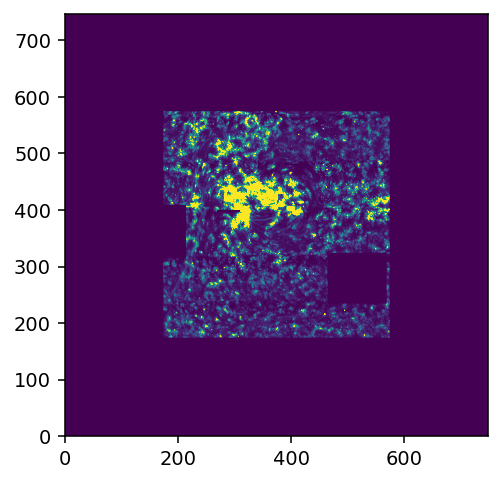

In [7]:
intensity = region.sum(-1)
intensity_wcs = wcs.dropaxis(0)


fig = plt.figure(dpi=140)
ax = fig.add_subplot()
img = ax.imshow(intensity.T,  vmin=0, vmax=np.percentile(intensity, 99), origin='lower')

Compute projections via the forward model. Any values less than zero in the `projections` array are set to $10^{-6}$

In [8]:
# region[region <= 0] = 1
spectral_order = 1
angles = (np.linspace(0, 180 , 4, endpoint=False)+22.5) * u.deg

print(angles)
# angles = np.array([31, 91, 151 ]) * u.deg
rotation_kwargs = {
    'reshape': False,
    'prefilter': False,
    'order': 1,
    'mode': 'constant',
    'cval': 0,
}
projections = mart.helper.generate_projections(
    data=region,
    angles=angles,
    spectral_order=spectral_order,
    poisson_noise=True,
    rotation_kwargs=rotation_kwargs

)
projections[projections <= 0] = 0
print('Projections complete')
print(projections.shape)

[ 22.5  67.5 112.5 157.5] deg
Projections complete
(1, 4, 768, 748, 1)


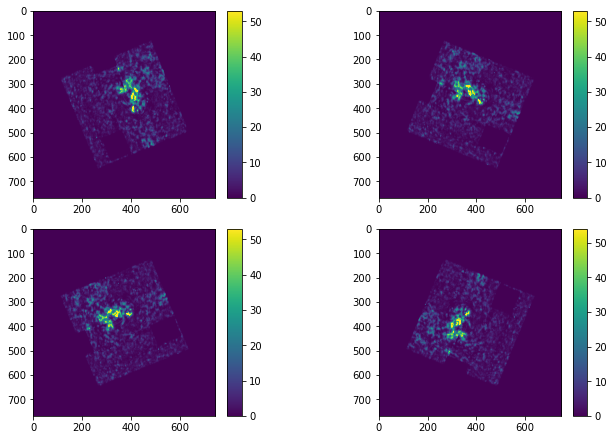

In [9]:
fig,axs = plt.subplots(2,2,figsize = (9.5,6),constrained_layout = True)
for ax,projection in zip(axs.flat,projections[0,...,0]):
    im = ax.imshow(projection,vmax = np.percentile(projection,99.9))
    fig.colorbar(im, ax = ax)

Now, we apply MART. The plot shows the recorded values of the `chi_sq` value as the algorithm iterates.
The orange indicates that LGOF-MART is being during that iteration.

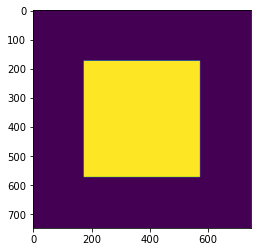

In [10]:
# generate a guess
guess = np.ones_like(region) * intensity.max()
# guess *= window
soft_border = border
guess[:soft_border, :, :] = 0
guess[~soft_border:, :, :] =0
guess[:, :soft_border, :] = 0
guess[:, ~soft_border:, :] =0

fig, ax = plt.subplots()
ax.imshow(guess[...,0])

In [11]:
mart_obj = mart.MART(
    verbose=True,
    use_maximize=True,
    use_filter=True,
    use_lgof = False,
    anti_aliasing=False,
    max_multiplicative_iteration=10,
    max_filtering_iterations=45,
    track_cube_history='filter',
    contrast_exponent=.2,
    rotation_kwargs=rotation_kwargs
)


recovered = mart_obj(
    projections,
    angles,
    np.array(spectral_order),
    # region.shape,
    cube_guess=guess
)

---------------------------------------------
Filtering Iteration Number  0
Starting MART Iterations
MART Converged at iteration  5
---------------------------------------------
Filtering Iteration Number  1
Starting MART Iterations
MART Converged at iteration  0
---------------------------------------------
Filtering Iteration Number  2
Starting MART Iterations
MART Converged at iteration  1
---------------------------------------------
Filtering Iteration Number  3
Starting MART Iterations
MART Converged at iteration  2
---------------------------------------------
Filtering Iteration Number  4
Starting MART Iterations
MART Converged at iteration  1
---------------------------------------------
Filtering Iteration Number  5
Starting MART Iterations
MART Converged at iteration  2
---------------------------------------------
Filtering Iteration Number  6
Starting MART Iterations
MART Converged at iteration  1
---------------------------------------------
Filtering Iteration Number  7


/media/jake/Media/Documents/Research/Kankelborg Group/ESIS/esis/data/inversion/mart/simple_mart.py:146: RuntimeWarning: invalid value encountered in true_divide
  ratio = projection / test_projection
/media/jake/Media/Documents/Research/Kankelborg Group/ESIS/esis/data/inversion/mart/forward.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  shifted_projection[tuple(out_sl)] = projection[in_sl]
/media/jake/Media/Documents/Research/Kankelborg Group/ESIS/esis/data/inversion/mart/forward.py:174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


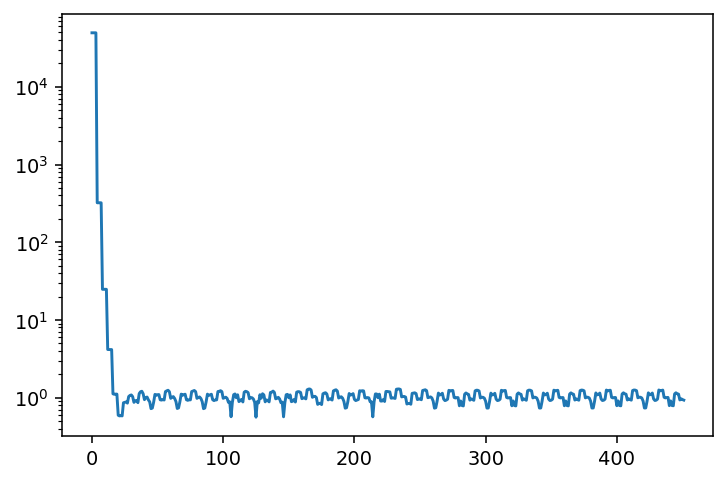

In [12]:
plt.figure(dpi=140)
plt.yscale('log')
plt.plot(recovered.chisq_history)
plt.plot(recovered.mart_type_history)

43


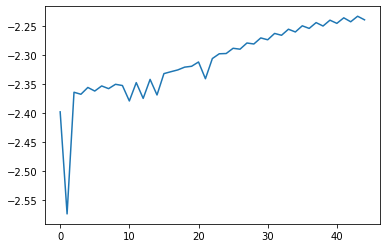

In [13]:
plt.plot(recovered.norm_history)
print(recovered.best_filtering_iteration)


Some comparison plots. First, the original against the recovered.

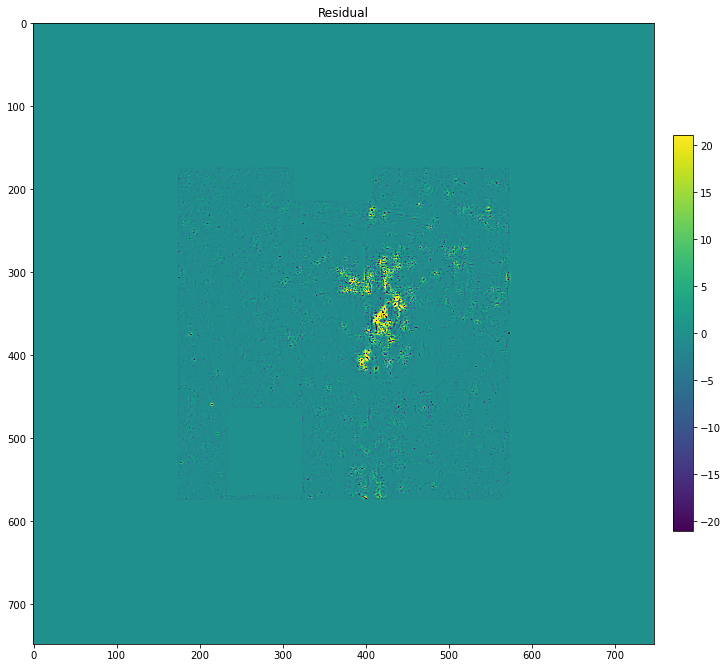

In [14]:
intensity_original = region.sum(~0)
intensity_recovered = recovered.best_cube.sum(~0)
intensity_recovered = recovered.cube_history[30].sum(~0)

residual_original =  intensity_recovered - intensity_original
upper_thresh = np.percentile(intensity_original, 99)
lower_thresh = np.percentile(intensity_original,  1)

# fig, ax = plt.subplots(ncols=3, nrows=1, dpi=140, figsize=(8, 3), constrained_layout=True)
# fig.suptitle('Comparison between Original and Recovered')
# img0 = ax[0].imshow(intensity_original, vmin=lower_thresh, vmax=upper_thresh)
# img1 = ax[1].imshow(intensity_recovered, vmin=lower_thresh, vmax=upper_thresh)
# residual_thresh = np.percentile(residual_original,99)
# img2 = ax[2].imshow(residual_original, vmin=-residual_thresh, vmax=residual_thresh )
#
# ax[0].set_title('Original')
# ax[1].set_title('Recovered')
# ax[2].set_title('Residual')
#
# _ = fig.colorbar(img0, ax=ax[0], shrink=0.55)
# _ = fig.colorbar(img1, ax=ax[1], shrink=0.55)
# _ = fig.colorbar(img2, ax=ax[2], shrink=0.55)

fig, ax = plt.subplots(constrained_layout=True, figsize=(10,10))
residual_thresh = np.percentile(residual_original,99.9)
img2 = ax.imshow(residual_original, vmin=-residual_thresh, vmax=residual_thresh )
ax.set_title('Residual')
_ = fig.colorbar(img2, ax=ax, shrink=0.55)

Now, compare the recovered against a smoothed version of the original. Here, the smoothing is generated by convolving 
each spectral slice in the original cube with the average "rotation smoothing" that is generated by playing with
`scipy.ndimage.rotate`.

1.0


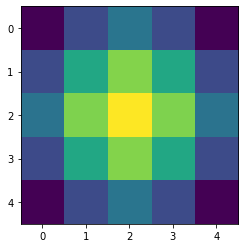

In [15]:
nx, ny, nwav = region.shape
nfreq = 5

rando = kgpy.fft.random.power_law_image(nx, ny, 0, 100, 2)
rand_border = int(np.ceil((1 / 2) * (nx) * (1 - np.sqrt(2) / 2))) + 1

cval = 0
rando[:rand_border, :,] = cval
rando[~rand_border:, :,] = cval
rando[:, :rand_border,] = cval
rando[:, ~rand_border:,] = cval

spec_img = kgpy.fft.power.spec2d(rando[border:~border,border:~border], nfreq, retain_dc=False)
kernel = np.zeros((nfreq, nfreq, angles.size))

for j, a in enumerate(angles):
    rot = scipy.ndimage.rotate(rando, a, **rotation_kwargs)
    rot = scipy.ndimage.rotate(rot, -a, **rotation_kwargs)
    spec_rot = kgpy.fft.power.spec2d(rot[border:~border, border:~border], nfreq, retain_dc=False)
    kernel[:, :, j] = np.roll(spec_rot/spec_img, shift=(nfreq//2, nfreq//2), axis=(0,1))
    
kernel = kernel.mean(~0)
kernel /= kernel.sum()
plt.imshow(kernel)
print(kernel.sum()) 
intensity_smoothed = scipy.signal.convolve(intensity, kernel, mode='same', method='direct')

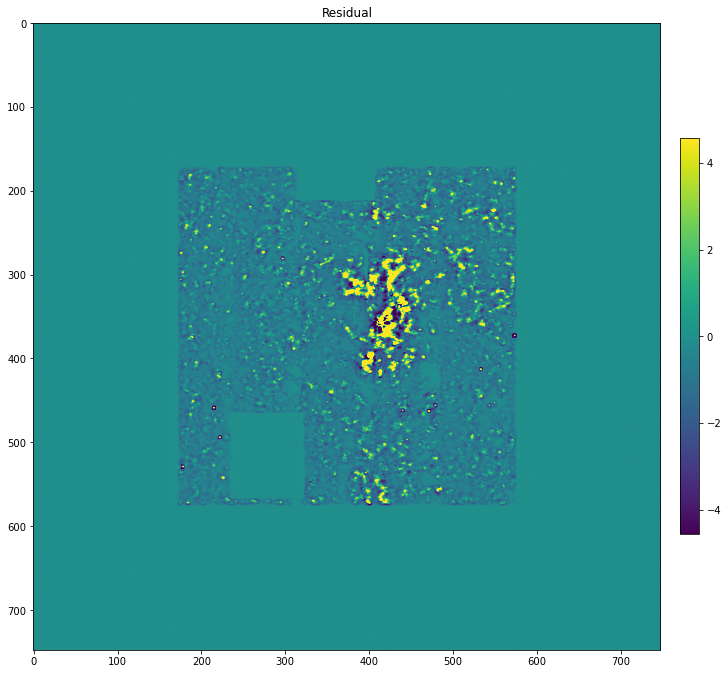

In [16]:
# intensity_smoothed = mart.antialias.apply(region, x_axis_index=~2, y_axis_index=~1).sum(~0)
residual_smoothed = intensity_recovered - intensity_smoothed

# fig, ax = plt.subplots(ncols=3, nrows=1, dpi=140, figsize=(8, 3), constrained_layout=True)
# fig.suptitle('Comparison between Smoothed and Recovered')
# img0 = ax[0].imshow(intensity_smoothed, vmin=lower_thresh, vmax=upper_thresh)
# img1 = ax[1].imshow(intensity_recovered, vmin=lower_thresh, vmax=upper_thresh)
# residual_thresh = np.percentile(residual_smoothed,99)
# img2 = ax[2].imshow(residual_smoothed, vmin=-residual_thresh, vmax=residual_thresh )
#
# ax[0].set_title('Smoothed Original')
# ax[1].set_title('Recovered')
# ax[2].set_title('Residual')
#
# _ = fig.colorbar(img0, ax=ax[0], shrink=0.55)
# _ = fig.colorbar(img1, ax=ax[1], shrink=0.55)
# _ = fig.colorbar(img2, ax=ax[2], shrink=0.55)

fig, ax = plt.subplots(constrained_layout=True, figsize=(10,10))
residual_thresh = np.percentile(residual_original,99)
img2 = ax.imshow(residual_smoothed, vmin=-residual_thresh, vmax=residual_thresh )
ax.set_title('Residual')
_ = fig.colorbar(img2, ax=ax, shrink=0.55)

## Spectral Profile Comparison

Take a given value of $y$ in the image,
see how reconstructed spectrum differs from actual and actual-smoothed.


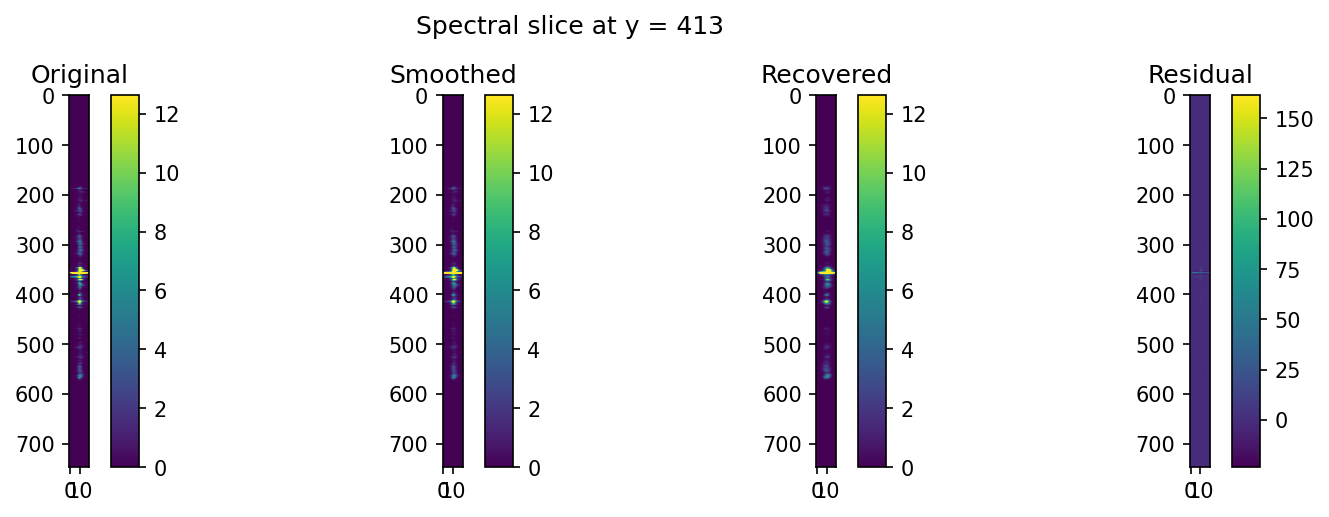

In [17]:
# y_index = border + 75
y_index = np.unravel_index(intensity_recovered.argmax(),intensity_recovered.shape)[-1]
test_spectrum = region[:, y_index,:]
smoothed_test_spectrum = mart.antialias.apply(test_spectrum, x_axis_index=~1, y_axis_index=~0)
recovered_spectrum = recovered.cube_history[-1][:, y_index, :]
residual_spectrum = test_spectrum - recovered_spectrum

spectrum_aspect = 1/2

upper_spec_thresh = np.percentile(test_spectrum, 99.5)
lower_spec_thresh = np.percentile(test_spectrum, .1)

fig, ax = plt.subplots(ncols=4, nrows=1, dpi=150, figsize=(15/1.5, 5/1.5), constrained_layout=True)
ax = ax.flatten()
fig.suptitle('Spectral slice at y = ' + str(y_index))
img0 = ax[0].imshow(test_spectrum, vmin=lower_spec_thresh, vmax=upper_spec_thresh , aspect=spectrum_aspect)
ax[0].set_title('Original')
img1 = ax[1].imshow(smoothed_test_spectrum, vmin=lower_spec_thresh, vmax=upper_spec_thresh, aspect=spectrum_aspect)
ax[1].set_title('Smoothed')
img2 = ax[2].imshow(recovered_spectrum, vmin=lower_spec_thresh, vmax=upper_spec_thresh, aspect=spectrum_aspect)
ax[2].set_title('Recovered')
img3 = ax[3].imshow(residual_spectrum,  aspect=spectrum_aspect)
ax[3].set_title('Residual')

_ = fig.colorbar(img0, ax=ax[0], aspect=40)
_ = fig.colorbar(img1, ax=ax[1], aspect=40)
_ = fig.colorbar(img2, ax=ax[2], aspect=40)
_ = fig.colorbar(img3, ax=ax[3], aspect=40)

## Some statistics

Create histogram plots. The red line is $y=x$.
The white contours are the 25th and 75th percentile in each column, and the orange is the 50th.

In [18]:
# intensity_percentile = 75
nbins = 100
base_wavelength = 1393.7570 * u.AA
wavelength_rebin_factor = 2
plotted_cube = recovered.cube_history[50]
# plotted_cube = recovered.best_cube



t0, t1, t2, t3 = mosaics.line_profile_moments.first_four_moments(
    region,
    base_wavelength=base_wavelength, 
    wcs=wcs, 
    wscale=wavelength_rebin_factor
)

p0, p1, p2, p3 = mosaics.line_profile_moments.first_four_moments(
    plotted_cube,
    base_wavelength=base_wavelength,
    wcs=wcs,
    wscale=wavelength_rebin_factor,
)

smoothed_region = mart.antialias.apply(region)
print(smoothed_region.shape)
print(region.shape)
s0, s1, s2, s3 = mosaics.line_profile_moments.first_four_moments(
    smoothed_region,
    base_wavelength=base_wavelength,
    wcs=wcs,
    wscale=wavelength_rebin_factor
)



# intensity_thresh = np.percentile(t0, intensity_percentile)
mask = t0 > brightest_pixel/100
print(mask)

# For some reason, the tetraptych plotting function broke and converting everything to np arrays is how I got it to work
t0 = t0[mask]
t1 = t1[mask].to_value(u.km/u.s)
t2 = t2[mask].to_value(u.km/u.s)
t3 = t3[mask].to_value(u.km/u.s)

p0 = p0[mask]
p1 = p1[mask].to_value(u.km/u.s)
p2 = p2[mask].to_value(u.km/u.s)
p3 = p3[mask].to_value(u.km/u.s)

s0 = s0[mask]
s1 = s1[mask].to_value(u.km/u.s)
s2 = s2[mask].to_value(u.km/u.s)
s3 = s3[mask].to_value(u.km/u.s)


xlabels = (
    'true intensity (arb. units)',
    'true shift (km / s)',
    'true width (km / s)',
    'true skew (km / s)'
)

ylabels = (
    'recovered intensity  (arb. units)',
    'recovered shift  (km / s)',
    'recovered width  (km / s)',
    'recovered skew  (km / s)'
)

figure = mart.stats.histogram_tetraptych(
    x=(t0, t1, t2, t3),
    y=(p0, p1, p2, p3),
    percentile_threshold_x = .1,
    percentile_threshold_y = .1,
    num_histogram_bins=100,
    x_axis_labels=xlabels,
    y_axis_labels=ylabels,
    red_line = True,
    interquartile_contour=True,
    min_iqr_count=10
)
figure.suptitle('True vs Recovered')

sxlabels = (
    'true smoothed intensity (arb. units)',
    'true smoothed shift (km / s)',
    'true smoothed width (km / s)',
    'true smoothed skew (km / s)'
)

figure2 = mart.stats.histogram_tetraptych(
    x=(s0, s1, s2, s3),
    y=(p0, p1, p2, p3),
    percentile_threshold_x = .1,
    percentile_threshold_y = .1,
    num_histogram_bins=100,
    x_axis_labels=sxlabels,
    y_axis_labels=ylabels,
    red_line = True,
    interquartile_contour=True,
    min_iqr_count=10
)
figure2.suptitle('Smoothed True vs Recovered')

IndexError: list index out of range

## Kolmogorov-Smirnov-like test

Perform a KS-like test on each pixel, displaying the max jump between the cumulative sums
along the wavelength axis between the recovered cube and the original cube. 
 * Make a "smoothed" version of the original data cube, using `mart.antialias.apply`
 * For both the (now smootherd) original data cube and the recovered data cube, produce a cumulative sum array.
 * Normalize: Divide each $xy$-column by the total intensity in that pixel (across all wavelengths)
 * Subtract one cube from the other, take the absolute value, then plot the max difference for each $xy$ pixel

First, make a smoothed version of the original data cube:

In [ ]:
# smoothed_region = mart.antialias.apply(region)
smoothed_region = region

Now, do a cumulative sum on each the smoothed and recovered cubes, and show the max deviation in each pixel
as an image in $xy$

In [ ]:
cumulative_recovered = np.cumsum(recovered.best_cube, axis=~0)
cumulative_recovered /= np.sum(recovered.best_cube, axis=~0)[:, :, None]

cumulative_smooth_true = np.cumsum(smoothed_region, axis=~0)
cumulative_smooth_true /= np.sum(smoothed_region, axis=~0)[:, :, None]

ks_cube = np.abs(cumulative_recovered - cumulative_smooth_true)
ks_condensed_by_max = np.amax(ks_cube, axis=~0)

border_sl = slice(border,-border)
inner_square = ks_condensed_by_max[border_sl, border_sl]
small_smoothed_original = np.sum(smoothed_region, axis=~0)[border_sl, border_sl]

ks_fig, ks_ax = plt.subplots(1, 2, dpi=140)

ksimg0 = ks_ax[0].imshow(inner_square, vmin=np.percentile(inner_square, 0.1), vmax=np.percentile(inner_square, 99.9))
ks_ax[0].set_title('KS Test Max Differences')

ksimg1 = ks_ax[1].imshow(small_smoothed_original, vmin=np.percentile(small_smoothed_original, 0.1), vmax=np.percentile(small_smoothed_original, 99.9))
ks_ax[1].set_title('Smoothed Original')

_ = ks_fig.colorbar(ksimg0, ax=ks_ax[0])
_ = ks_fig.colorbar(ksimg1, ax=ks_ax[1])

It seems that the largest error in the KS like test, for each pixel as a column, 
generally is worse when the values of the data are small.


